# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from scipy.stats import poisson

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

import thinkbayes2
import thinkplot

import pymc3 as pm
import theano.tensor as T

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.
/home/cgirard/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Fake data

In [16]:
n = 60
t1 = 30
t2 = n-t1
lam1 = 4
lam2 = 2
t = 30

In [17]:
before = poisson(lam1).rvs(t1)

In [18]:
after = poisson(lam2).rvs(t2)

In [19]:
data = np.concatenate([before, after])

### Grid algorithm

In [32]:
# Doesnt work ehhhh

class Change(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: array of counts
        hypo: t, lam1, lam2
        """
        t, lam1, lam2 = hypo
        total = 0
        for i in range(len(data)):
            if i < t:
               like = poisson.pmf(data[i], lam1)
            else:
                like = poisson.pmf(data[i], lam2)
            total *= like
        return total

In [39]:
class ChangeClass(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: array of counts
        hypo: t, lam1, lam2
        """
        t, lam1, lam2 = hypo
        before = data[:t]
        after = data[t:]
        like1 = np.prod(poisson.pmf(before, lam1))
        like2 = np.prod(poisson.pmf(after,lam2))
        return like1*like2

In [40]:
ts = range(len(data))
lams = np.linspace(0,10,11);

from itertools import product

hypos = product(ts, lams, lams)

In [50]:
classchange = ChangeClass(hypos)

In [51]:
classchange.Update(data)

1.3209595335137782e-50

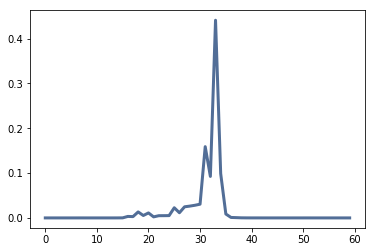

In [56]:
tau = classchange.Marginal(0)
thinkplot.Pdf(tau)

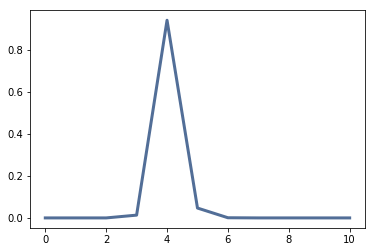

In [57]:
lam1 = classchange.Marginal(1)
thinkplot.Pdf(lam1)

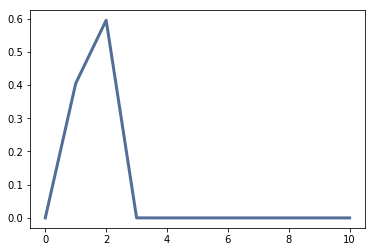

In [58]:
lam2 = classchange.Marginal(2)
thinkplot.Pdf(lam2)

### MCMC

To implement this model in PyMC, see Chapter 1 of [Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb)
and this example from [Computational Statistics in Python](http://people.duke.edu/~ccc14/sta-663-2016/16C_PyMC3.html#Changepoint-detection)

In [74]:
early = 4
late = 2
y = np.r_[np.random.poisson(early, 30), np.random.poisson(late, 60)]

In [75]:

niter = 10000
t = range(len(y))
with pm.Model() as change_point:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(y), testval=len(y)//2)
    mu0 = pm.Exponential('mu0', 1/y.mean())
    mu1 = pm.Exponential('mu1', 1/y.mean())
    mu = T.switch(t < cp, mu0, mu1)
    Y_obs = pm.Poisson('Y_obs', mu=mu, observed=y)
    trace = pm.sample(niter)

Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4361.93draws/s]


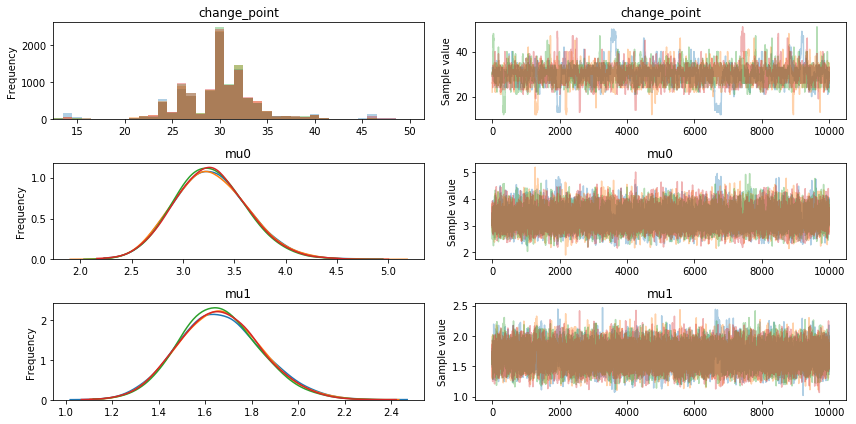

In [76]:
pm.traceplot(trace, varnames=['change_point', 'mu0', 'mu1'])
pass


### Real data

Some real data, based on [this analysis from the Baltimore Sun](http://www.baltimoresun.com/news/maryland/crime/bs-md-ci-violence-stats-20181018-story.html)

In [61]:
!wget https://raw.githubusercontent.com/baltimore-sun-data/2018-shootings-analysis/master/BPD_Part_1_Victim_Based_Crime_Data.csv

--2018-10-26 15:05:47--  https://raw.githubusercontent.com/baltimore-sun-data/2018-shootings-analysis/master/BPD_Part_1_Victim_Based_Crime_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45658084 (44M) [text/plain]
Saving to: ‘BPD_Part_1_Victim_Based_Crime_Data.csv’

BPD_Part_1_Victim_B 100%[===================>]  43.54M  28.0MB/s    in 1.6s    

2018-10-26 15:05:48 (28.0 MB/s) - ‘BPD_Part_1_Victim_Based_Crime_Data.csv’ saved [45658084/45658084]



In [62]:
df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv', parse_dates=[0])
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,crimeCaseNumber,Total Incidents
0,2018-07-07,23:53:00,1F,1600 PENTWOOD RD,HOMICIDE,NaN,FIREARM,413.0,NORTHEASTERN,Stonewood-Pentwood-Winsto,-76.58727,39.34782,"(39.34782, -76.58727)",Alley,NaN,1.0
1,2018-07-07,23:50:00,4E,ST & DIVISION ST,COMMON ASSAULT,O,NaN,131.0,CENTRAL,Druid Heights,-76.63936,39.30903,"(39.30903, -76.63936)",STREET,NaN,1.0
2,2018-07-07,23:18:00,4C,2500 PERRING MANOR RD,AGG. ASSAULT,I,OTHER,423.0,NORTHEASTERN,Hamilton Hills,-76.56094,39.37189,"(39.37189, -76.56094)",ROW/TOWNHO,NaN,1.0
3,2018-07-07,22:41:00,9S,3700 S HANOVER ST,SHOOTING,NaN,FIREARM,913.0,SOUTHERN,Brooklyn,-76.61033,39.23703,"(39.23703, -76.61033)",Common Bus,NaN,1.0
4,2018-07-07,22:55:00,4E,LOMBARD ST & LIGHT ST,COMMON ASSAULT,I,NaN,111.0,CENTRAL,Inner Harbor,-76.61362,39.28775,"(39.28775, -76.61362)",CONVENIENC,NaN,1.0


In [63]:
df.shape

(329456, 16)

In [64]:
shootings = df[df.Description.isin(['HOMICIDE', 'SHOOTING']) & (df.Weapon == 'FIREARM')]
shootings.shape

(5295, 16)

In [65]:
grouped = shootings.groupby('CrimeDate')

In [66]:
counts = grouped['Total Incidents'].sum()
counts.head()

CrimeDate
2012-01-01    1.0
2012-01-03    2.0
2012-01-05    1.0
2012-01-06    2.0
2012-01-07    3.0
Name: Total Incidents, dtype: float64

In [67]:
index = pd.date_range(counts.index[0], counts.index[-1])

In [68]:
counts = counts.reindex(index, fill_value=0)
counts.head()

2012-01-01    1.0
2012-01-02    0.0
2012-01-03    2.0
2012-01-04    0.0
2012-01-05    1.0
Freq: D, Name: Total Incidents, dtype: float64

AttributeError: module 'thinkplot' has no attribute 'decorate'

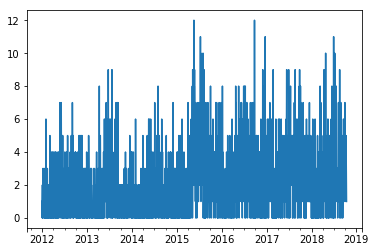

In [69]:
counts.plot()
thinkplot.decorate(xlabel='Date',
                   ylabel='Number of shootings')